In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import re
import tqdm
import statistics
import time
import sys
import ast
import json
import scipy
import logging
import matplotlib.pyplot as plt
#import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Dict
from data.make_data import get_links, is_article, save_links, extract_links, get_date_from_url, extract_links_main
from eval_utils import *

sys.path.append('../hot_links')
# TODO Something like this in dataset.py
# from hot_links.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

from hot_links.vector_db_utils import *

np.random.seed(41)
logger = logging.getLogger(__name__)


In [8]:
vs_name = 'hot_links'

vector_store_id = get_vector_store_id(vs_name = vs_name)

if not vector_store_id:
    print('Creating...')
    logger.info('Creating vs {vs_name}')
    vector_store_id = create_vs(vs_name)
    
logger.info('Set up {vs_name}')

In [4]:
df_seed = pd.read_csv('../data/processed/seed.csv')
## Assumes you haven't done snowballing

df_seed['links'] = df_seed['links'].apply(ast.literal_eval)

In [81]:
test_article = df_seed.iloc[5,:]

In [82]:
test_article_links = [d['href']+'.txt' for d in test_article['links']]
test_article_snippets = [d['link'] for d in test_article['links']]

## Just search for content of document

In [10]:
n_eval = 10

all_names, all_ranks, all_totals, all_scores, all_true_totals = [],[],[],[],[]

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    query = str(row[1]['bodyContent'])[:4096]
    # VS query limited to 4096 chars
    

    names, ranks, scores, total = get_matched_links(vector_store_id,query,row[1], v = False)

    all_names.append(names)
    all_ranks.append(ranks)
    all_totals.append(total)
    all_scores.append(scores)
    all_true_totals.append(total)

10it [00:18,  1.89s/it]


In [11]:
n_zero_matches = len(list(filter(lambda x:len(x)==0, all_ranks)))

n_found = len([item for sublist in all_ranks for item in sublist])
n_to_find = sum(all_true_totals)

print('{:d} articles have no link matches ({:.2f}%)'.format(n_zero_matches,100* (n_zero_matches/float(n_eval))))

print('{:d} links found out of {:d} ({:.2f}%)'.format(n_found, n_to_find,100* (n_found/n_to_find)))

print('Median rank is {:.1f}'.format(statistics.median([item for sublist in all_ranks for item in sublist])))

5 articles have no link matches (50.00%)
12 links found out of 21 (57.14%)
Median rank is 8.5


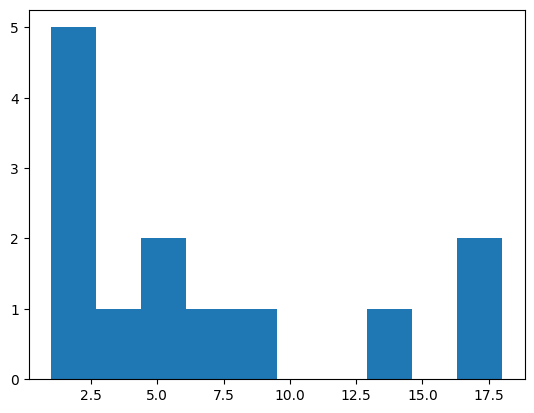

In [118]:
_ = plt.hist([item for sublist in all_ranks for item in sublist])
#item['href'] for sublist in all_article_links for item in sublist

## Search for specific snippet

In [10]:
test_article = df_seed.iloc[5,:]

test_article_links = [d['href']+'.txt' for d in test_article['links']]
test_article_snippets = [d['link'] for d in test_article['links']]

n_test = 2
# Which link number in article to test

In [11]:
for n_test in range(len(test_article_links)):
    print(n_test,test_article_snippets[n_test])

0 spoken to Greg Dyke
1 Sebastian Coe regarding doping
2 Chris Kermode of the ATP on the subject of match-fixing
3 Change Cricket campaign


In [12]:
query = 'I want to add a link at this point\n\
{:s}\n \
in the article below. Which document would be best?\n\
    {:s}'.format(test_article_snippets[n_test],test_article['bodyContent'][:4096])

In [13]:
results = client.vector_stores.search(
    vector_store_id=vector_store_id,
    query=query[:4096],
    max_num_results = 20
)

In [14]:
results =[r for r in results if not r.filename == test_article.webUrl+'.txt']
# Drop original article from results

In [15]:
print(test_article_snippets[n_test])
print(test_article_links[n_test])

Change Cricket campaign
https://www.theguardian.com/commentisfree/2015/jul/31/money-made-cricket-poorer-ashes-rooten-state-governance.txt


In [15]:
n_eval = 5

all_matches = []
all_scores = []

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    matches, scores = get_matches_snippet(vector_store_id,row[1])
    #print(matches)
    all_matches.append(matches)
    all_scores.append(scores)

0it [00:00, ?it/s]

5it [00:16,  3.36s/it]


In [58]:
all_matches_flat = [item for sublist in all_matches for item in sublist]
all_scores_flat = [item for sublist in all_scores for item in sublist]

scores_for_zeros = [score for score,rank in zip(all_scores_flat,all_matches_flat) if rank == 0]

n_no_match = len(list(filter(lambda x:x==-999,all_matches_flat)))
match_ranks = list(filter(lambda x:x != -999,all_matches_flat))

print('Out of {:d} articles and {:d} total links ({:.2f} av.)'.format(n_eval,len(all_matches_flat),len(all_matches_flat)/n_eval))
print('{:d} links not found ({:.2f}%)'.format(n_no_match,100*(n_no_match/len(all_matches_flat))))
print('Median rank is {:.1f} (mean rank is {:.2f})'.format(statistics.median(match_ranks),statistics.mean(match_ranks)))
print('Mean score for zero ranked matches is {:.2f}'.format(statistics.mean(scores_for_zeros)))

Out of 5 articles and 17 total links (3.40 av.)
6 links not found (35.29%)
Median rank is 1.0 (mean rank is 1.73)
Mean score for zero ranked matches is 0.59


## Search for matches with time constraint

In [16]:
n_eval = 10

all_names, all_ranks, all_totals, all_scores, all_true_totals = [],[],[],[],[]

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    query = str(row[1]['bodyContent'])[:4096]
    # VS query limited to 4096 chars
    
    epoch_date = get_date_from_url(row[1]['webPublicationDate'])

    names, ranks, scores, total = get_matched_links(vector_store_id,query,row[1], v = False, time_stamp=epoch_date,window_days=14)

    all_names.append(names)
    all_ranks.append(ranks)
    all_totals.append(total)
    all_scores.append(scores)
    all_true_totals.append(total)

10it [00:23,  2.35s/it]


In [17]:
n_zero_matches = len(list(filter(lambda x:len(x)==0, all_ranks)))

n_found = len([item for sublist in all_ranks for item in sublist])
n_to_find = sum(all_true_totals)

print('{:d} articles have no link matches ({:.2f}%)'.format(n_zero_matches,100* (n_zero_matches/float(n_eval))))

print('{:d} links found out of {:d} ({:.2f}%)'.format(n_found, n_to_find,100* (n_found/n_to_find)))

print('Median rank is {:.1f}'.format(statistics.median([item for sublist in all_ranks for item in sublist])))

4 articles have no link matches (40.00%)
9 links found out of 14 (64.29%)
Median rank is 4.0


## Search for snippets with time constraint

In [18]:
n_eval = 10

all_matches = []
all_scores = []

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    
    epoch_date = get_date_from_url(row[1]['webPublicationDate'])

    matches, scores = get_matches_snippet(vector_store_id,row[1], v = False,time_stamp=epoch_date,window_days=14)
    #print(matches)
    all_matches.append(matches)
    all_scores.append(scores)

0it [00:00, ?it/s]

10it [00:43,  4.40s/it]


In [19]:
all_matches_flat = [item for sublist in all_matches for item in sublist]
all_scores_flat = [item for sublist in all_scores for item in sublist]

scores_for_zeros = [score for score,rank in zip(all_scores_flat,all_matches_flat) if rank == 0]

n_no_match = len(list(filter(lambda x:x==-999,all_matches_flat)))
match_ranks = list(filter(lambda x:x != -999,all_matches_flat))

print('Out of {:d} articles and {:d} total links ({:.2f} av.)'.format(n_eval,len(all_matches_flat),len(all_matches_flat)/n_eval))
print('{:d} links not found ({:.2f}%)'.format(n_no_match,100*(n_no_match/len(all_matches_flat))))
print('Median rank is {:.1f} (mean rank is {:.2f})'.format(statistics.median(match_ranks),statistics.mean(match_ranks)))
print('{:d} matches were at rank 0 ({:.1f}% of all links)'.format(len(scores_for_zeros),100*(len(scores_for_zeros)/len(all_matches_flat))))
print('Mean score for zero ranked matches is {:.2f}'.format(statistics.mean(scores_for_zeros)))

Out of 10 articles and 21 total links (2.10 av.)
8 links not found (38.10%)
Median rank is 3.0 (mean rank is 4.31)
4 matches were at rank 0 (19.0% of all links)
Mean score for zero ranked matches is 0.51
